## Tweet Emotion Recognition: Natural Language Processing with TensorFlow


## Setup and Imports



In [1]:
!pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00


In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from datasets import load_dataset


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Importing Data


In [81]:
#pip install datasets

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
dataset = load_dataset('emotion')

In [54]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']


In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [21]:
tweets[0],labels[0]

('i didnt feel humiliated', 0)

## Tokenizer

1. Tokenizing the tweets

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [14]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Padding and Truncating Sequences


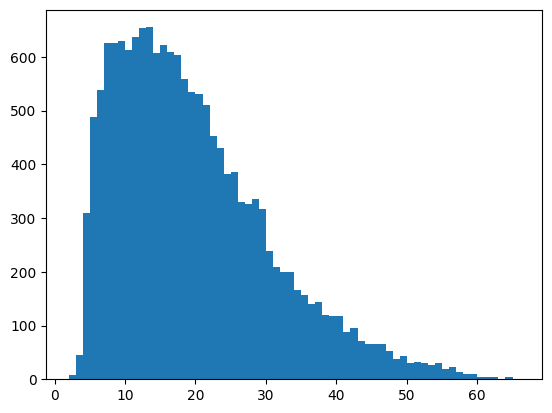

In [15]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [16]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [56]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [52]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [19]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels



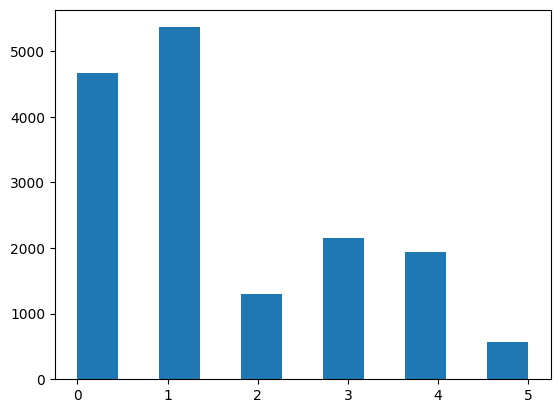

In [24]:
plt.hist(labels, bins=11)
plt.show();

In [25]:
def get_emotion_dict():
    return {
        0: 'sadness',
        1: 'joy',
        2: 'love',
        3: 'anger',
        4: 'fear',
        5: 'surprise'
    }

# Przykład użycia
emotion_dict = get_emotion_dict()
emotion_dict

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [66]:
def get_emotion_label(index):
    emotion_map = {
        0: 'sadness',
        1: 'joy',
        2: 'love',
        3: 'anger',
        4: 'fear',
        5: 'surprise'
    }
    return emotion_map.get(index)

# Przykład użycia
print(get_emotion_label(labels[0]))

sadness


## Creating the Model

In [74]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [75]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training the Model



In [57]:
val_tweets, val_labels = get_tweet(val)
_, train_labels = get_tweet(train)
val_seq = get_sequences(tokenizer, val_tweets)

2000

In [58]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [59]:
h = model.fit(
    padded_train_sequences, np.array(train_labels),
    validation_data=(val_seq, np.array(val_labels)),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8862 - loss: 0.3326 - val_accuracy: 0.8380 - val_loss: 0.4942
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9345 - loss: 0.2049 - val_accuracy: 0.8555 - val_loss: 0.4708
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9513 - loss: 0.1522 - val_accuracy: 0.8650 - val_loss: 0.4554
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9656 - loss: 0.1088 - val_accuracy: 0.8755 - val_loss: 0.4332
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9539 - loss: 0.1512 - val_accuracy: 0.8825 - val_loss: 0.4346
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9765 - loss: 0.0779 - val_accuracy: 0.8800 - val_loss: 0.4490
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9774 - loss: 0.0767 - val_accuracy: 0.8930 - val_loss: 0.4149
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9846 - loss: 0.0523 - val_ac

##Evaluating the Model



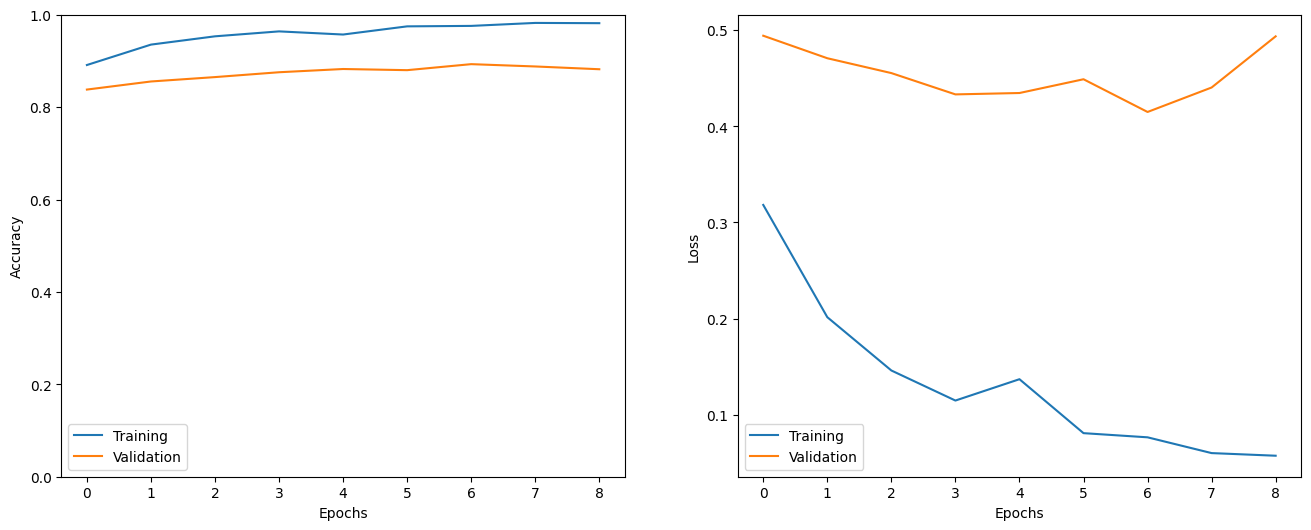

In [60]:
show_history(h)

In [62]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)

In [64]:
_ = model.evaluate(test_seq, np.array(test_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8657 - loss: 0.5514


In [68]:
i = random.randint(0,len(test_labels) - 1)

print('Sentence', test_tweets[i])
print('Emotion', get_emotion_label(test_labels[i]))

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = get_emotion_label(np.argmax(p).astype('uint8'))
print('Predicted Emotion', pred_class)

Sentence i always feel so pressured
Emotion fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
Predicted Emotion fear


In [69]:
preds = model.predict(test_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


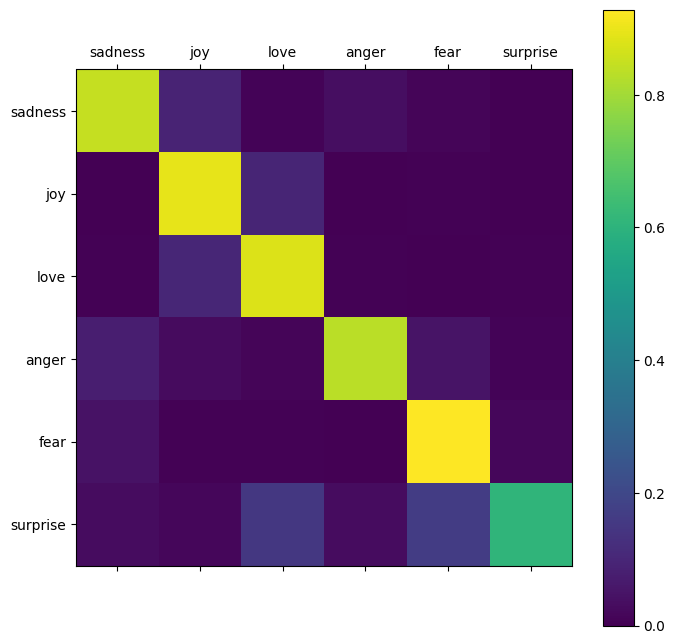

In [73]:
pred_classes = np.argmax(preds, axis=1)
classes = ['sadness',
        'joy',
        'love',
        'anger',
        'fear',
        'surprise']
show_confusion_matrix(test_labels, pred_classes, classes)